This notebook tries to identify images of polyps in intestine that can help in early detection of colorectal cancer


Dataset link: https://paperswithcode.com/dataset/medico-automatic-polyp-segmentation-challenge#:~:text=Automatic%20Polyp%20Segmentation-,The%20“Medico%20automatic%20polyp%20segmentation%20challenge”%20aims%20to%20develop%20computer,with%20high%20efficiency%20and%20accuracy.
Download dataset from here https://datasets.simula.no/kvasir-seg/ to the ./data folder and replace the path while instantiating dataset

In [1]:
!rm -rf ./DL_Proj/
!rm -rf ./FCBFormer/
!git clone --single-branch --branch theerath https://github.com/rpathak38/DL_Proj.git
!git clone https://github.com/ESandML/FCBFormer temp_dir
!mv temp_dir/* temp_dir/.* .
!rmdir temp_dir
!pip install timm

Cloning into 'DL_Proj'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 66 (delta 21), reused 18 (delta 8), pack-reused 28
Receiving objects: 100% (66/66), 27.70 MiB | 27.22 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Cloning into 'temp_dir'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 79 (delta 35), reused 20 (delta 2), pack-reused 0
Receiving objects: 100% (79/79), 2.28 MiB | 10.10 MiB/s, done.
Resolving deltas: 100% (35/35), done.
mv: cannot move 'temp_dir/.' to './.': Device or resource busy
mv: cannot move 'temp_dir/..' to './..': Device or resource busy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.6 MB/s eta 0:00:00


In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import requests
import zipfile
import timm

In [3]:
url = 'https://datasets.simula.no/downloads/kvasir-seg.zip'
local_filename = url.split('/')[-1]

# Download the file
response = requests.get(url, stream=True)
with open(local_filename, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:  # filter out keep-alive new chunks
            f.write(chunk)

# Unzip the file
with zipfile.ZipFile(local_filename, 'r') as zip_ref:
    zip_ref.extractall('.')

# Remove the zip file
os.remove(local_filename)

In [4]:
url = 'https://github.com/whai362/PVT/releases/download/v2/pvt_v2_b3.pth'
local_filename = url.split('/')[-1]

# Download the file
response = requests.get(url, stream=True)
with open(local_filename, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:  # filter out keep-alive new chunks
            f.write(chunk)

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.train = train

        # List all image and mask files
        self.image_files = sorted([f for f in os.listdir(os.path.join(root_dir, 'images')) if f.endswith('.jpg')])
        self.mask_files = sorted([f for f in os.listdir(os.path.join(root_dir, 'masks')) if f.endswith('.jpg')])

        # Split dataset into train and test
        if self.train:
            self.image_files = self.image_files[:800]
            self.mask_files = self.mask_files[:800]
        else:
            self.image_files = self.image_files[800:]
            self.mask_files = self.mask_files[800:]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        img_path = os.path.join(self.root_dir, 'images', self.image_files[idx])
        mask_path = os.path.join(self.root_dir, 'masks', self.mask_files[idx])
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # Preprocess the mask
        mask = self.process_mask(mask)

        # Apply transformations
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return {'image': image, 'mask': mask}

    def process_mask(self, mask):
        # Convert mask values as per your requirement
        mask[mask <= 8] = 0
        mask[mask >= 246] = 255
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        return mask

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((256, 256))
    transforms.Resize((352, 352))]) # The FCB model uses this size

# train_dataset = CustomDataset(root_dir='/root/GATech/cs7643/polyps_detection/data/Kvasir-SEG', transform=transform, train=True)
# val_dataset = CustomDataset(root_dir='/root/GATech/cs7643/polyps_detection/data/Kvasir-SEG', transform=transform, train=False)
train_dataset = CustomDataset(root_dir='/content/Kvasir-SEG', transform=transform, train=True)
val_dataset = CustomDataset(root_dir='/content/Kvasir-SEG', transform=transform, train=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


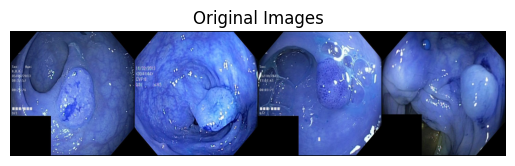

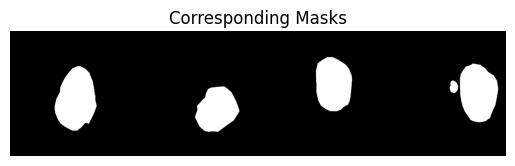

In [7]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF

def reverse_transform(tensor):
    """Converts a PyTorch tensor to a NumPy array for visualization."""
    image = tensor.cpu().clone()
    image = image.squeeze(0)  # Remove batch dimension
    image = TF.to_pil_image(image)
    return np.array(image)

# Visualize some random samples from the test dataset
num_samples = 4

for batch in val_loader:
    images, masks = batch['image'], batch['mask']
    break  # Break after the first batch

# Visualize original images
grid_images = make_grid(images[:num_samples], nrow=num_samples)
plt.imshow(reverse_transform(grid_images))
plt.title('Original Images')
plt.axis('off')
plt.show()

# Visualize corresponding masks
grid_masks = make_grid(masks[:num_samples], nrow=num_samples)
plt.imshow(reverse_transform(grid_masks), cmap='gray')
plt.title('Corresponding Masks')
plt.axis('off')
plt.show()


In [8]:
len(train_loader)

50

In [9]:
# Check for CUDA availability
from DL_Proj.unet import UNet
from Models import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def init_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight)

# Initialize the model
# model = UNet(3, 1, [64, 128, 256, 512])
model = models.FCBFormer()

# Move the model to the CUDA device if available
model = model.to(device)

epochs = 30
lr = 0.001
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

/content/Models/pvt_v2.py:332: UserWarning: Overwriting pvt_v2_b0 in registry with Models.pvt_v2.pvt_v2_b0. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def pvt_v2_b0(pretrained=False, **kwargs):
/content/Models/pvt_v2.py:343: UserWarning: Overwriting pvt_v2_b1 in registry with Models.pvt_v2.pvt_v2_b1. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def pvt_v2_b1(pretrained=False, **kwargs):
/content/Models/pvt_v2.py:354: UserWarning: Overwriting pvt_v2_b2 in registry with Models.pvt_v2.pvt_v2_b2. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def pvt_v2_b2(pretrained=False, **kwargs):
/content/Models/pvt_v2.py:364: UserWarning: Overwriting pvt_v2_b3 in registry with Models.pvt_v2.pvt_v2_b3. This is because the name being registered conflicts with an existing name. Please check if thi

Using device: cuda


In [10]:
def pixel_acc(outputs, mask):
    outputs = (outputs > 0.5).float()  # Convert probability to binary prediction
    correct_pixels = torch.eq(outputs, mask).float().sum()
    total_pixels = mask.numel()
    accuracy = correct_pixels / total_pixels
    return accuracy

def calculate_iou(outputs, mask):
    outputs = (outputs > 0.5).float()
    intersection = torch.logical_and(outputs, mask).sum()
    union = torch.logical_or(outputs, mask).sum()
    iou = intersection / union if union != 0 else 0.0
    return iou

def dice_index(outputs, mask):
    smooth = 1e-5
    outputs = (outputs > 0.5).float()
    intersection = torch.sum(outputs * mask)
    union = torch.sum(outputs) + torch.sum(mask)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

In [11]:

# # Training and validation code
# for epoch in range(epochs):
#     print(f"EPOCH {epoch}:")
#     model.train()
#     batch_loss = batch_acc = batch_iou=batch_pacc=0.0

#     for batch in tqdm(train_loader, desc=f"Training Loop, Epoch: {epoch}"):
#         # Move data to CUDA
#         img, mask = batch['image'], batch['mask']
#         img, mask = img.to(device), mask.to(device)
#         optimizer.zero_grad()
#         outs = model(img)
#         # loss=dice_loss(outs, mask)
#         loss=criterion(outs,mask)
#         # loss = class_balanced_focal_ce_loss(outs, mask, weights=class_weights, gamma=2)
#         loss.backward()
#         optimizer.step()

#         with torch.no_grad():
#             accuracy = dice_index(outs, mask)
#             iou=calculate_iou(outs,mask)
#             pacc=pixel_acc(outs,mask)
#             batch_loss += loss.item()
#             batch_acc += accuracy.item()
#             batch_iou+=iou
#             batch_pacc+=pacc

#     batch_loss /= len(train_loader)
#     batch_acc /= len(train_loader)
#     batch_iou/=len(train_loader)
#     batch_pacc/=len(train_loader)
#     print(f"Training loss: {batch_loss}, Training accuracy: {batch_pacc}, DICE:{batch_acc} ,IOU: {batch_iou}")
#     model.eval()
#     val_loss = val_acc = val_iou=val_pacc=0.0

#     with torch.no_grad():
#         sample_printed = False
#         for batch in tqdm(val_loader, desc=f"Validation Loop, Epoch: {epoch}"):
#             # Move data to CUDA
#             img, mask = batch['image'], batch['mask']
#             img, mask = img.to(device), mask.to(device)


#             outs = model(img)
#             loss=criterion(outs, mask)
#             iou=calculate_iou(outs,mask)
#             pacc=pixel_acc(outs,mask)
#             accuracy = dice_index(outs, mask)
#             val_loss += loss.item()
#             val_acc += accuracy.item()
#             val_iou+=iou
#             val_pacc+=pacc

#             if not sample_printed:
#                 sample_printed = True
#                 idx = 0  # Choose the index of the sample to print
#                 sample_img = img[idx].cpu().numpy().transpose((1, 2, 0))
#                 sample_mask = mask[idx].cpu().numpy()
#                 sample_pred = outs[idx].cpu().numpy()

#                 plt.figure(figsize=(10, 5))
#                 plt.subplot(1, 3, 1)
#                 plt.imshow(sample_img)
#                 plt.title("Input Image")

#                 plt.subplot(1, 3, 2)

#                 # Check if the mask is 2D or 3D
#                 if sample_mask.ndim == 3 and sample_mask.shape[0] == 1:
#                     sample_mask = sample_mask[0]  # Remove the singleton dimension

#                 plt.imshow(sample_mask, cmap='gray')
#                 plt.title("Ground Truth Mask")

#                 plt.subplot(1, 3, 3)

#                 # Check if the prediction is 2D or 3D
#                 if sample_pred.ndim == 3 and sample_pred.shape[0] == 1:
#                     sample_pred = sample_pred[0]  # Remove the singleton dimension

#                 plt.imshow(sample_pred, cmap='gray')
#                 plt.title("Predicted Mask")

#                 plt.show()

#     val_loss /= len(val_loader)
#     val_acc /= len(val_loader)
#     val_iou/=len(val_loader)
#     val_pacc/=len(val_loader)
#     print(f"Validation loss: {val_loss}, Validation accuracy: {val_pacc},DICE:{val_acc},IOU: {val_iou}")

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_parameters(model)
print(f"Number of parameters in the U-Net model: {num_params}")

Number of parameters in the U-Net model: 52962337


### Student model with distillation

In [13]:
from DL_Proj.unet import UNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def init_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight)

# Initialize the model
student_model = UNet(3, 1, [64, 128, 256])

# Move the model to the CUDA device if available
student_model = student_model.to(device)

epochs = 30
lr = 0.001
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=student_model.parameters(), lr=lr)

Using device: cuda


In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_parameters(student_model)
print(f"Number of parameters in the U-Net model: {num_params}")

Number of parameters in the U-Net model: 4651778


In [15]:
for param in model.parameters():
    param.requires_grad = False

In [16]:
import torch.nn.functional as F
def distillation_loss(outputs, labels, teacher_outputs):
    # soft_target = torch.nn.functional.softmax(teacher_outputs / temperature, dim=1)
    # soft_output = torch.nn.functional.log_softmax(outputs / temperature, dim=1)
    N = outputs.shape[0]
    outputs=outputs.view(N, -1)
    teacher_outputs = teacher_outputs.view(N, -1)

    outputs = F.normalize(outputs, p=1, dim=1)
    teacher_outputs = F.normalize(teacher_outputs, p=1, dim=1)


    outputs = F.log_softmax(outputs, dim=1)
    kl_divergence = F.kl_div(outputs, teacher_outputs, reduction='batchmean')

    return kl_divergence

In [ ]:
for epoch in range(epochs):
    print(f"EPOCH {epoch}:")
    batch_loss = batch_acc = batch_iou=batch_pacc=0.0

    student_model.train()
    model.eval()

    for batch in tqdm(train_loader, desc=f"Training Loop, Epoch: {epoch}"):
        img, mask = batch['image'], batch['mask']
        img, mask = img.to(device), mask.to(device)

        # Forward pass with the larger U-Net to get teacher outputs
        with torch.no_grad():
            teacher_outputs = model(img)

        optimizer.zero_grad()

        # Forward pass with the smaller U-Net
        outputs = student_model(img)

        # Compute the knowledge distillation loss
        kd_loss = distillation_loss(outputs, mask, teacher_outputs)

        # Add your segmentation loss (e.g., cross-entropy or dice loss)
        segmentation_loss = criterion(outputs, mask)

        # Combine the knowledge distillation loss and the segmentation loss
        total_loss = kd_loss + segmentation_loss

        total_loss.backward()
        optimizer.step()
        with torch.no_grad():
            accuracy = dice_index(outputs, mask)
            iou=calculate_iou(outputs,mask)
            pacc=pixel_acc(outputs,mask)
            batch_loss += total_loss.item()
            batch_acc += accuracy.item()
            batch_iou+=iou
            batch_pacc+=pacc

    batch_loss /= len(train_loader)
    batch_acc /= len(train_loader)
    batch_iou/=len(train_loader)
    batch_pacc/=len(train_loader)
    print(f"Training loss: {batch_loss}, Training accuracy: {batch_pacc}, DICE:{batch_acc} ,IOU: {batch_iou}")
    student_model.eval()
    val_loss = val_acc = val_iou=val_pacc=0.0

    with torch.no_grad():
        sample_printed = False
        for batch in tqdm(val_loader, desc=f"Validation Loop, Epoch: {epoch}"):
            # Move data to CUDA
            img, mask = batch['image'], batch['mask']
            img, mask = img.to(device), mask.to(device)


            outs = student_model(img)
            loss=criterion(outs, mask)
            iou=calculate_iou(outs,mask)
            pacc=pixel_acc(outs,mask)
            accuracy = dice_index(outs, mask)
            val_loss += loss.item()
            val_acc += accuracy.item()
            val_iou+=iou
            val_pacc+=pacc

            if not sample_printed:
                sample_printed = True
                idx = 0  # Choose the index of the sample to print
                sample_img = img[idx].cpu().numpy().transpose((1, 2, 0))
                sample_mask = mask[idx].cpu().numpy()
                sample_pred = outs[idx].cpu().numpy()

                plt.figure(figsize=(10, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(sample_img)
                plt.title("Input Image")

                plt.subplot(1, 3, 2)

                # Check if the mask is 2D or 3D
                if sample_mask.ndim == 3 and sample_mask.shape[0] == 1:
                    sample_mask = sample_mask[0]  # Remove the singleton dimension

                plt.imshow(sample_mask, cmap='gray')
                plt.title("Ground Truth Mask")

                plt.subplot(1, 3, 3)

                # Check if the prediction is 2D or 3D
                if sample_pred.ndim == 3 and sample_pred.shape[0] == 1:
                    sample_pred = sample_pred[0]  # Remove the singleton dimension

                plt.imshow(sample_pred, cmap='gray')
                plt.title("Predicted Mask")

                plt.show()

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_iou/=len(val_loader)
    val_pacc/=len(val_loader)
    print(f"Validation loss: {val_loss}, Validation accuracy: {val_pacc},DICE:{val_acc},IOU: {val_iou}")


EPOCH 0:


Training Loop, Epoch: 0:  46%|████▌     | 23/50 [00:55<00:56,  2.10s/it]

## student model without distillation

In [ ]:
# Check for CUDA availability
from unet import UNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def init_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight)

# Initialize the model
small_model = UNet(3, 1, [64, 128, 256])

# Move the model to the CUDA device if available
small_model = small_model.to(device)

epochs = 30
lr = 0.001
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=small_model.parameters(), lr=lr)
# Training and validation code
for epoch in range(epochs):
    print(f"EPOCH {epoch}:")
    small_model.train()
    batch_loss = batch_acc = batch_iou=batch_pacc=0.0

    for batch in tqdm(train_loader, desc=f"Training Loop, Epoch: {epoch}"):
        # Move data to CUDA
        img, mask = batch['image'], batch['mask']
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()
        outs = small_model(img)
        # loss=dice_loss(outs, mask)
        loss=criterion(outs,mask)
        # loss = class_balanced_focal_ce_loss(outs, mask, weights=class_weights, gamma=2)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            accuracy = dice_index(outs, mask)
            iou=calculate_iou(outs,mask)
            pacc=pixel_acc(outs,mask)
            batch_loss += loss.item()
            batch_acc += accuracy.item()
            batch_iou+=iou
            batch_pacc+=pacc

    batch_loss /= len(train_loader)
    batch_acc /= len(train_loader)
    batch_iou/=len(train_loader)
    batch_pacc/=len(train_loader)
    print(f"Training loss: {batch_loss}, Training accuracy: {batch_pacc}, DICE:{batch_acc} ,IOU: {batch_iou}")
    small_model.eval()
    val_loss = val_acc = val_iou=val_pacc=0.0

    with torch.no_grad():
        sample_printed = False
        for batch in tqdm(val_loader, desc=f"Validation Loop, Epoch: {epoch}"):
            # Move data to CUDA
            img, mask = batch['image'], batch['mask']
            img, mask = img.to(device), mask.to(device)


            outs = small_model(img)
            loss=criterion(outs, mask)
            iou=calculate_iou(outs,mask)
            pacc=pixel_acc(outs,mask)
            accuracy = dice_index(outs, mask)
            val_loss += loss.item()
            val_acc += accuracy.item()
            val_iou+=iou
            val_pacc+=pacc

            if not sample_printed:
                sample_printed = True
                idx = 0  # Choose the index of the sample to print
                sample_img = img[idx].cpu().numpy().transpose((1, 2, 0))
                sample_mask = mask[idx].cpu().numpy()
                sample_pred = outs[idx].cpu().numpy()

                plt.figure(figsize=(10, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(sample_img)
                plt.title("Input Image")

                plt.subplot(1, 3, 2)

                # Check if the mask is 2D or 3D
                if sample_mask.ndim == 3 and sample_mask.shape[0] == 1:
                    sample_mask = sample_mask[0]  # Remove the singleton dimension

                plt.imshow(sample_mask, cmap='gray')
                plt.title("Ground Truth Mask")

                plt.subplot(1, 3, 3)

                # Check if the prediction is 2D or 3D
                if sample_pred.ndim == 3 and sample_pred.shape[0] == 1:
                    sample_pred = sample_pred[0]  # Remove the singleton dimension

                plt.imshow(sample_pred, cmap='gray')
                plt.title("Predicted Mask")

                plt.show()

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_iou/=len(val_loader)
    val_pacc/=len(val_loader)
    print(f"Validation loss: {val_loss}, Validation accuracy: {val_pacc},DICE:{val_acc},IOU: {val_iou}")